In [15]:
import os
os.chdir("/Users/mammoc/Desktop/Python")
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway
from scipy.stats import kruskal

In [3]:
airport = pd.read_csv("airport_original1.csv", sep = ';', header = 0)

In [4]:
# Dropping rows where 'Destination' is 4
airport = airport[airport['Destination'] != 4]

In [5]:
###-------------- STEP 1: FILLING UP NAs ----------------

#Drop NAs in Destination
airport = airport.dropna(subset=['Destination'])

#Age has 1 missing value (ID 214) => Replace by average age of 40
airport.loc[airport['ID'] == 214, 'Age'] = 40

#Gender has 3 missing values (ID 179, 199, 259)
# => Fill up by most frequency category - female - 2.0
airport.loc[airport['ID'].isin([179, 199, 259]), 'Gender'] = 2.0

#SeatClass has 3 missing value 
#Fill up by most frequency category = 1.0
airport.loc[airport['ID'].isin([245, 255, 450, 475]), 'SeatClass'] = 1.0

#AccessTime:
AccessTime_by_ProvinceResidence = airport.groupby('ProvinceResidence')['AccessTime'].mean()
airport['AccessTime'] = airport.apply(
    lambda row: AccessTime_by_ProvinceResidence[row['ProvinceResidence']] if pd.isnull(row['AccessTime']) 
    else row['AccessTime'],axis=1)

#Noticeable Difference in Airfare Between Legacy Airlines and Others
#print(airport.groupby('Airline[Legacy]')['Airfare'].mean())
#print(airport.groupby('Airline[Legacy]')['Airfare'].median())
# Recategorize 'Airline' into binary categories: 'Legacy' and 'Other'
airport['Airline[Legacy]'] = airport['Airline'].isin([1, 2]).astype(int)

#Airfare:
# Calculate the mean 'Airfare' for each combination of 'Airline_Legacy','Destination'
Airfare_by_Airline_Destination = airport.groupby(['Airline[Legacy]','Destination'])['Airfare'].mean()
#Fill the missing values in 'Airfare' with the average values calculated above
airport['Airfare'] = airport.apply(
    lambda row: Airfare_by_Airline_Destination[row['Airline[Legacy]'], row['Destination']] if pd.isnull(row['Airfare']) 
    else row['Airfare'], axis=1)

In [ ]:
###-------------- STEP 2: EDA ----------------
### EDA will be conducted based on nature of each variables, using: 
#(1) Visualization, (2) ANOVA test, (2)KRUSKAL-WALLIS H-test, (3) CHI-SQUARE

Mean age by Aiport:
Airport
1    38.408257
2    41.543568
Name: Age, dtype: float64


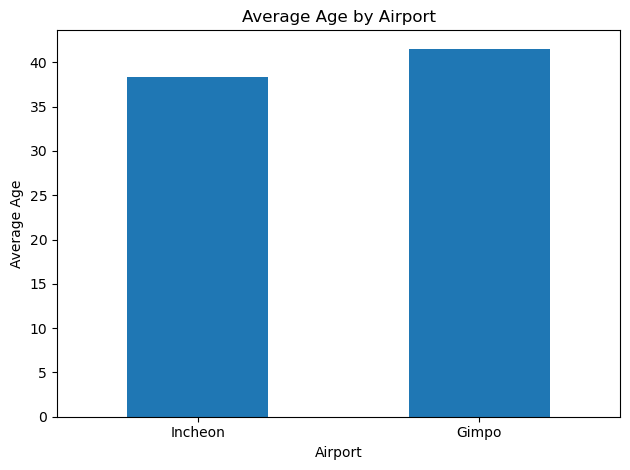

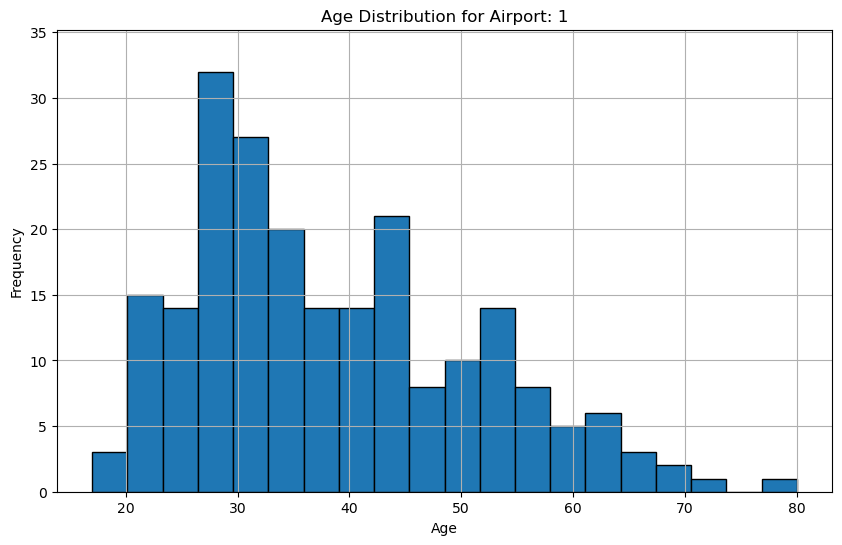

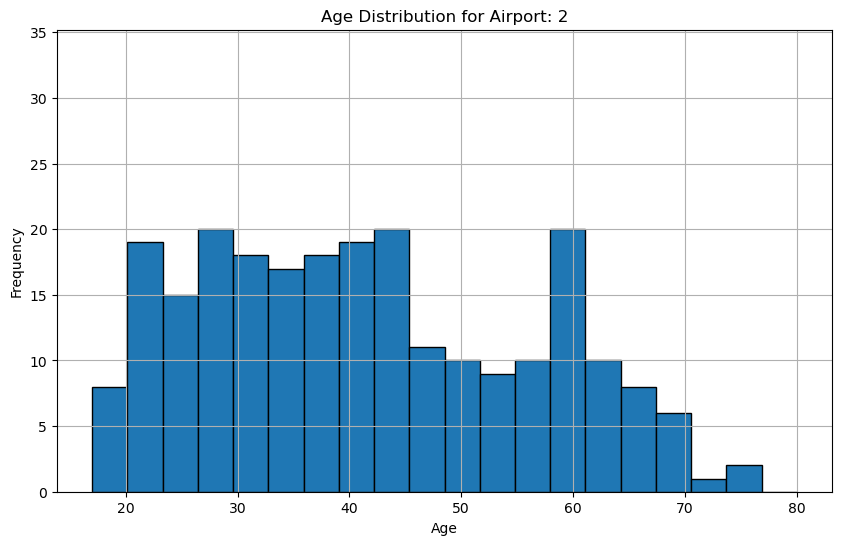


ANOVA test result:
The p-value is greater than or equal to 0.01 , so we fail to reject the null hypothesis.
There is no statistically significant difference in average age between Airport 1 and Airport 2.


In [28]:
# -------- AGE ---------
print('Mean age by Aiport:')
print(airport.groupby('Airport')['Age'].mean())

#(1)Visualization
avg_age_by_airport = airport.groupby('Airport')['Age'].mean()
avg_age_by_airport.index = ['Incheon', 'Gimpo']
avg_age_by_airport.plot(kind='bar')
plt.xlabel('Airport')
plt.ylabel('Average Age')
plt.title('Average Age by Airport')
plt.xticks(rotation=0)  
plt.tight_layout()
plt.show()

#Histogram - Check for Normal Distribution
grouped = airport.groupby('Airport')
age_min = airport['Age'].min()
age_max = airport['Age'].max()
max_count = 0
for name, group in grouped:
    counts, _ = np.histogram(group['Age'], bins=20, range=(age_min, age_max))
    max_count = max(max_count, counts.max())
for i, (name, group) in enumerate(grouped, start=1):
    plt.figure(figsize=(10, 6))
    counts, bins, patches = plt.hist(group['Age'], bins=20, edgecolor='black', range=(age_min, age_max))    
    plt.ylim(0, max_count * 1.1)  # Add a little extra space at the top    
    plt.title(f'Age Distribution for Airport: {name}')
    plt.xlabel('Age')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()
    

#ANOVA Test
airport_1 = airport[airport['Airport'] == 1]['Age']
airport_2 = airport[airport['Airport'] == 2]['Age']
anova_result = f_oneway(airport_1, airport_2)
alpha = 0.01
print('\nANOVA test result:')
if anova_result.pvalue < alpha:
    print("The p-value is less than", alpha, ", so we reject the null hypothesis.")
    print("There is a statistically significant difference in average age between Airport 1 and Airport 2.")
else:
    print("The p-value is greater than or equal to", alpha, ", so we fail to reject the null hypothesis.")
    print("There is no statistically significant difference in average age between Airport 1 and Airport 2.")

Airport  Gender
1        2.0       116
         1.0       102
2        2.0       132
         1.0       109
Name: count, dtype: int64


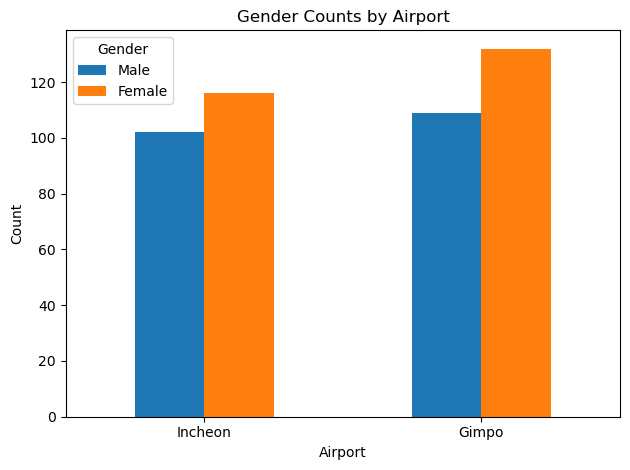


Chi-square test results:
Chi-square statistic: 0.058216329116466736
P-value: 0.8093376438501295

The p-value is greater than or equal to 0.05 , so we fail to reject the null hypothesis.
There is no statistically significant difference in the distribution of gender between Airport 1 and Airport 2.


In [49]:
# --------- GENDER ---------
print(airport.groupby(['Airport'])['Gender'].value_counts())

#Visualization:
gender_counts = airport.groupby('Airport')['Gender'].value_counts().rename('Count').reset_index()
pivot_table = gender_counts.pivot(index='Airport', columns='Gender', values='Count').fillna(0)
pivot_table.index = ['Incheon', 'Gimpo']
pivot_table.plot(kind='bar', stacked=False)
plt.xlabel('Airport')
plt.ylabel('Count')
plt.title('Gender Counts by Airport')
plt.xticks(ticks=[0, 1], labels=['Incheon', 'Gimpo'], rotation=0)  
plt.legend(title='Gender', labels=['Male', 'Female'])  
plt.tight_layout()
plt.show()

#Chi-square test:
contingency_table = pd.crosstab(airport['Airport'], airport['Gender'])
chi2, p, dof, expected = chi2_contingency(contingency_table)
print("\nChi-square test results:")
print("Chi-square statistic:", chi2)
print("P-value:", p)
alpha = 0.05
if p < alpha:
    print("\nThe p-value is less than", alpha, ", so we reject the null hypothesis.")
    print("There is a statistically significant difference in the distribution of gender between Airport 1 and Airport 2.")
else:
    print("\nThe p-value is greater than or equal to", alpha, ", so we fail to reject the null hypothesis.")
    print("There is no statistically significant difference in the distribution of gender between Airport 1 and Airport 2.")


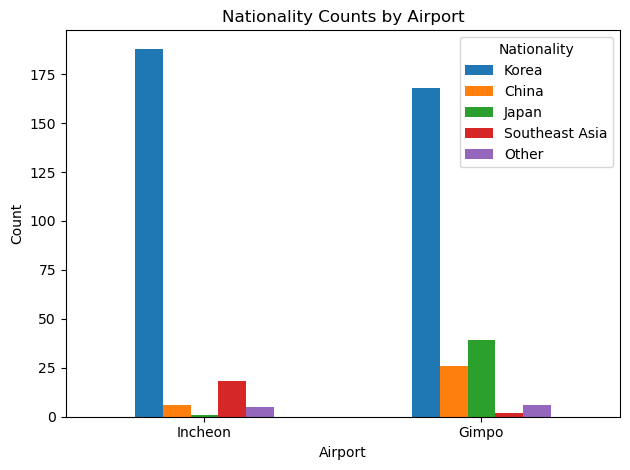

Chi-square test results for Nationality groups:
Chi-square statistic: 94.71039234988048
P-value: 2.130852960146831e-20
Degrees of freedom: 3
The p-value for Nationality groups is less than 0.05, so we reject the null hypothesis.
There is a statistically significant association between Nationality and Airport selection.


In [79]:
#-------- NATIONALITY ------------
#Visualization:
# Group by 'Airport' and get the count of each 'Nationality'
nationality_counts = airport.groupby('Airport')['Nationality'].value_counts().rename('Count').reset_index()
pivot_table = nationality_counts.pivot(index='Airport', columns='Nationality', values='Count').fillna(0)
pivot_table.index = ['Incheon', 'Gimpo']
pivot_table.plot(kind='bar', stacked=False)
plt.xlabel('Airport')
plt.ylabel('Count')
plt.title('Nationality Counts by Airport')
plt.xticks(ticks=[0, 1], labels=['Incheon', 'Gimpo'], rotation=0)  
plt.legend(title='Nationality', labels=['Korea', 'China', 'Japan', 'Southeast Asia', 'Other'])  
plt.tight_layout()
plt.show()

#Chi-square:
airport['Nationality[Korean]'] = (airport['Nationality'].isin([1])).astype(int)
airport['Nationality[Japan]'] = (airport['Nationality'].isin([3])).astype(int)
airport['Nationality[SE]'] = (airport['Nationality'].isin([4])).astype(int)
airport['Nationality[China]'] = (airport['Nationality'].isin([2])).astype(int)
contingency_table = np.array([
    airport['Nationality[Korean]'].value_counts(),
    airport['Nationality[Japan]'].value_counts(),
    airport['Nationality[SE]'].value_counts(),
    airport['Nationality[China]'].value_counts()
])

# Perform Chi-square test
chi2, p, dof, ex = chi2_contingency(contingency_table)

# Output the Chi-square test results
print(f"Chi-square test results for Nationality groups:\nChi-square statistic: {chi2}\nP-value: {p}\nDegrees of freedom: {dof}")

# Interpret the results with an alpha of 0.05
alpha = 0.05
if p < alpha:
    print(f"The p-value for Nationality groups is less than {alpha}, so we reject the null hypothesis.")
    print("There is a statistically significant association between Nationality and Airport selection.")
else:
    print(f"The p-value for Nationality groups is greater than or equal to {alpha}, so we fail to reject the null hypothesis.")
    print("There is no statistically significant association between Nationality and Airport selection.")


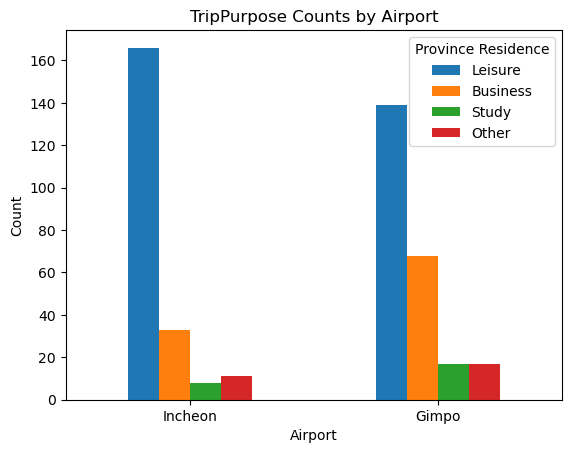

Chi-square test results for TripPurpose[Leisure] vs TripPurpose[Others]:
Chi-square statistic: 16.69672096895135
P-value: 4.3856736824948144e-05
Degrees of freedom: 1
The p-value for TripPurpose groups is less than 0.01, so we reject the null hypothesis.
There is a statistically significant association between TripPurpose and Airport selection.


In [29]:
#-------- TRIPPURPOSE ----------
#Visualization
TripPurpose_counts = airport.groupby('Airport')['TripPurpose'].value_counts().rename('Count').reset_index()
pivot_table = TripPurpose_counts.pivot(index='Airport', columns='TripPurpose', values='Count').fillna(0)
pivot_table.index = ['Incheon', 'Gimpo']
pivot_table.plot(kind='bar', stacked=False)
plt.xlabel('Airport')
plt.ylabel('Count')
plt.title('TripPurpose Counts by Airport')
plt.xticks(rotation=0)  
plt.legend(title='Province Residence', labels=['Leisure', 'Business', 'Study', 'Other'])  
plt.show()

#Chi-square:
airport['TripPurpose[Leisure]'] = (airport['TripPurpose'].isin([1])).astype(int)
airport['TripPurpose[Other]'] = (airport['TripPurpose'].isin([2,3,4])).astype(int)
contingency_table = pd.crosstab(index=airport['Airport'], columns=[airport['TripPurpose[Leisure]'], airport['TripPurpose[Other]']])
chi2, p, dof, ex = chi2_contingency(contingency_table)
print(f"Chi-square test results for TripPurpose[Leisure] vs TripPurpose[Others]:\nChi-square statistic: {chi2}\nP-value: {p}\nDegrees of freedom: {dof}")
alpha = 0.01
if p < alpha:
    print(f"The p-value for TripPurpose groups is less than {alpha}, so we reject the null hypothesis.")
    print("There is a statistically significant association between TripPurpose and Airport selection.")
else:
    print(f"The p-value for TripPurpose groups is greater than or equal to {alpha}, so we fail to reject the null hypothesis.")
    print("There is no statistically significant association between TripPurpose and Airport selection.")

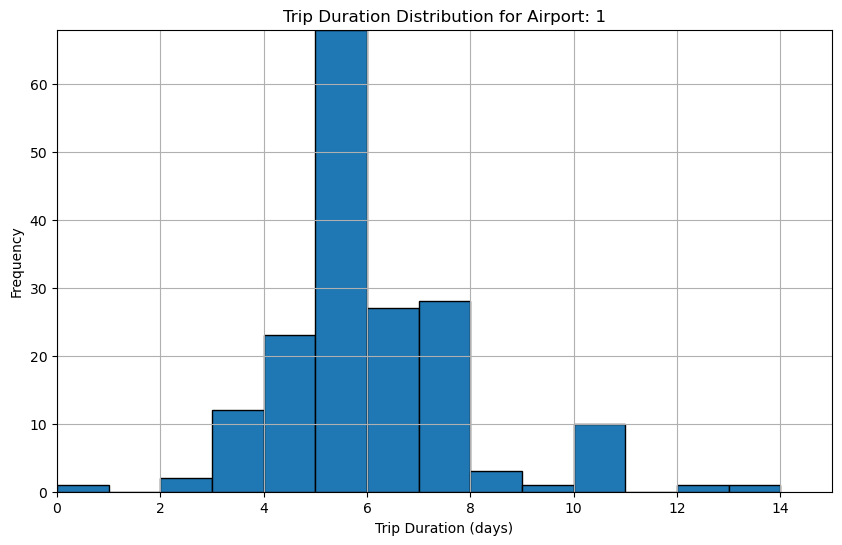

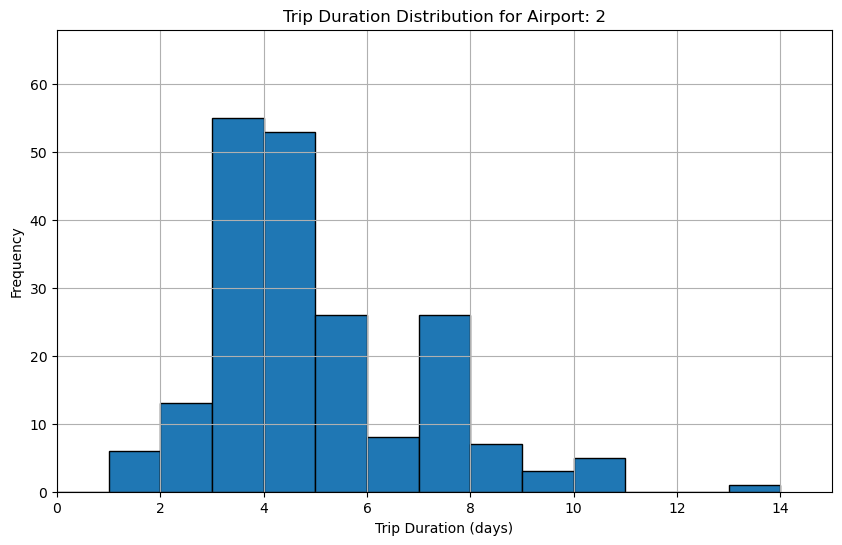

Sample size of each groups:
89
370

ANOVA test result:
The p-value is greater than or equal to 0.05 , so we fail to reject the null hypothesis.
There is no statistically significant difference in average Trip Duration between Airport 1 and Airport 2.

Chi-square test results for TripDuration[<4] vs TripDuration[>=4]:
Chi-square statistic: 40.056636586770495
P-value: 2.4670514491455695e-10
Degrees of freedom: 1
The p-value for TripDuration groups is less than 0.05, so we reject the null hypothesis.
There is a statistically significant association between TripDuration and Airport selection.

Chi-square test results for TripDuration[<6] vs TripDuration[>=6]:
Chi-square statistic: 9.686701110602641
P-value: 0.0018560647096948835
Degrees of freedom: 1
The p-value for TripDuration groups is less than 0.05, so we reject the null hypothesis.
There is a statistically significant association between TripDuration and Airport selection.


In [35]:
#-------- TRIPDURATION ----------
##Histogram - Check for Normal Distribution
# Filter out the outliers first
airport_filtered = airport[(airport['TripDuration'] <= 180)]
grouped = airport_filtered.groupby('Airport')
max_count = 0
for name, group in grouped:
    counts, _ = np.histogram(group['TripDuration'], bins=range(0, 15, 1))
    max_count = max(max_count, max(counts))
for name, group in grouped:
    plt.figure(figsize=(10, 6))
    plt.hist(group['TripDuration'], bins=range(0, 15, 1), edgecolor='black')
    plt.title(f'Trip Duration Distribution for Airport: {name}')
    plt.xlabel('Trip Duration (days)')
    plt.ylabel('Frequency')
    plt.ylim(0, max_count)  
    plt.xlim(0, 15)  
    plt.grid(True)
    plt.show()

#Check sample size of each group:
airport['TripDuration[<4]'] = (airport['TripDuration']<4).astype(int)
airport['TripDuration[>=4]'] = (airport['TripDuration']>=4).astype(int)
print('Sample size of each groups:')
print(airport['TripDuration[<4]'].sum())
print(airport['TripDuration[>=4]'].sum())

#ANOVA test:
airport_1 = airport[airport['Airport'] == 1]['TripDuration']
airport_2 = airport[airport['Airport'] == 2]['TripDuration']
anova_result = f_oneway(airport_1, airport_2)
alpha = 0.05
print('\nANOVA test result:')
if anova_result.pvalue < alpha:
    print("The p-value is less than", alpha, ", so we reject the null hypothesis.")
    print("There is a statistically significant difference in average Trip Duration between Airport 1 and Airport 2.")
else:
    print("The p-value is greater than or equal to", alpha, ", so we fail to reject the null hypothesis.")
    print("There is no statistically significant difference in average Trip Duration between Airport 1 and Airport 2.")
    
#CHI SQUARE for TripDuration[<4] vs TripDuration[>=4]
airport['TripDuration[<4]'] = (airport['TripDuration']<4).astype(int)
airport['TripDuration[>=4]'] = (airport['TripDuration']>=4).astype(int)
contingency_table = pd.crosstab(index=airport['Airport'], columns=[airport['TripDuration[<4]'], airport['TripDuration[>=4]']])
chi2, p, dof, ex = chi2_contingency(contingency_table)
print(f"\nChi-square test results for TripDuration[<4] vs TripDuration[>=4]:\nChi-square statistic: {chi2}\nP-value: {p}\nDegrees of freedom: {dof}")
alpha = 0.05
if p < alpha:
    print(f"The p-value for TripDuration groups is less than {alpha}, so we reject the null hypothesis.")
    print("There is a statistically significant association between TripDuration and Airport selection.")
else:
    print(f"The p-value for TripDuration groups is greater than or equal to {alpha}, so we fail to reject the null hypothesis.")
    print("There is no statistically significant association between TripDuration and Airport selection.")
    
#CHI SQUARE for TripDuration[<6] vs TripDuration[>=6]
airport['TripDuration[<6]'] = (airport['TripDuration']<6).astype(int)
airport['TripDuration[>=6]'] = (airport['TripDuration']>=6).astype(int)
contingency_table = pd.crosstab(index=airport['Airport'], columns=[airport['TripDuration[<6]'], airport['TripDuration[>=6]']])
chi2, p, dof, ex = chi2_contingency(contingency_table)
print(f"\nChi-square test results for TripDuration[<6] vs TripDuration[>=6]:\nChi-square statistic: {chi2}\nP-value: {p}\nDegrees of freedom: {dof}")
alpha = 0.05
if p < alpha:
    print(f"The p-value for TripDuration groups is less than {alpha}, so we reject the null hypothesis.")
    print("There is a statistically significant association between TripDuration and Airport selection.")
else:
    print(f"The p-value for TripDuration groups is greater than or equal to {alpha}, so we fail to reject the null hypothesis.")
    print("There is no statistically significant association between TripDuration and Airport selection.")

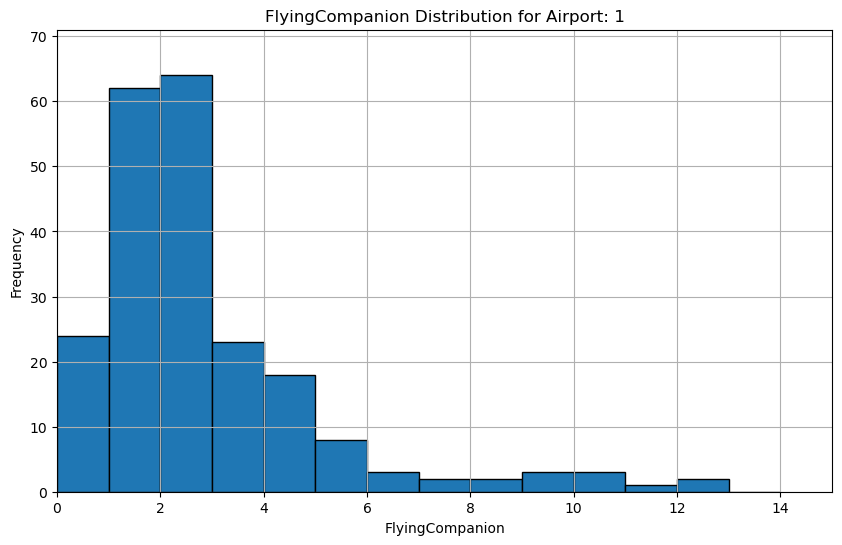

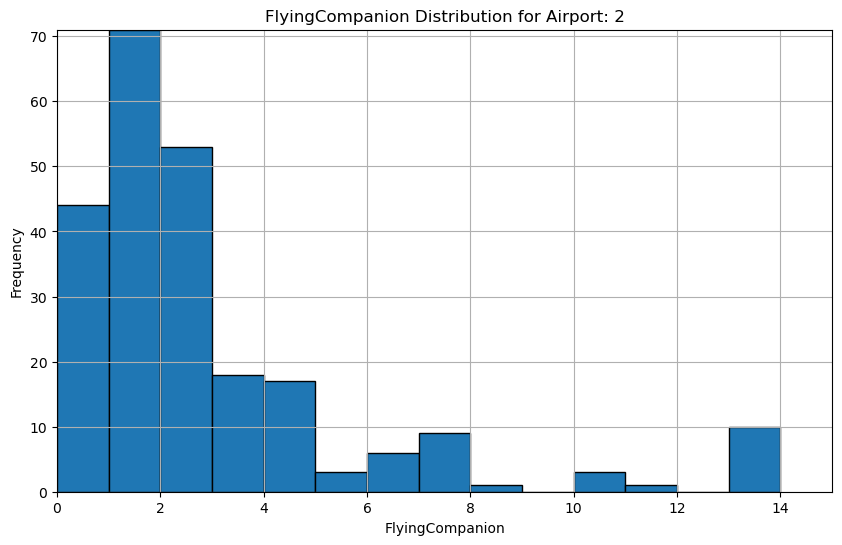

Sample size of each groups:
Airport
1    218
2    241
Name: FlyingCompanion, dtype: int64
\Kruskal-Wallis H Test test result:
The p-value is less than 0.05 , so we reject the null hypothesis.
There is a statistically significant difference in average Trip Duration between Airport 1 and Airport 2.


In [85]:
#--------- FLYING COMPANION -----------
##Histogram - Check for Normal Distribution
grouped = airport.groupby('Airport')
max_count = 0
for name, group in grouped:
    counts, _ = np.histogram(group['FlyingCompanion'], bins=range(0, 15, 1))
    max_count = max(max_count, max(counts))
for name, group in grouped:
    plt.figure(figsize=(10, 6))
    plt.hist(group['FlyingCompanion'], bins=range(0, 15, 1), edgecolor='black')
    plt.title(f'FlyingCompanion Distribution for Airport: {name}')
    plt.xlabel('FlyingCompanion')
    plt.ylabel('Frequency')
    plt.ylim(0, max_count) 
    plt.xlim(0, 15)  
    plt.grid(True)
    plt.show()
    
#Check for sample size of each group:
print('Sample size of each groups:')
print(airport.groupby('Airport')['FlyingCompanion'].count())
    

#ANOVA test:
airport_1 = airport[airport['Airport'] == 1]['TripDuration']
airport_2 = airport[airport['Airport'] == 2]['TripDuration']
#anova_result = f_oneway(airport_1, airport_2)
kruskal_result = kruskal(airport_1, airport_2)
alpha = 0.05
print('\Kruskal-Wallis H Test test result:')
if anova_result.pvalue < alpha:
    print("The p-value is less than", alpha, ", so we reject the null hypothesis.")
    print("There is a statistically significant difference in average Trip Duration between Airport 1 and Airport 2.")
else:
    print("The p-value is greater than or equal to", alpha, ", so we fail to reject the null hypothesis.")
    print("There is no statistically significant difference in average Trip Duration between Airport 1 and Airport 2.")

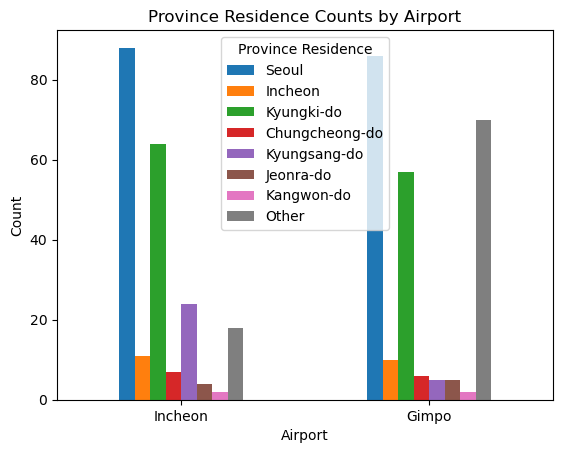

Sample size of each groups:
142
317
Chi-square test results:
Chi-square statistic: 2.0367958963843047, P-value: 0.15353274830879451
We fail to reject the null hypothesis: There is no significant association between ProvinceResidence groups and AirportChoice.


In [30]:
#-------- PROVINCERESIDENCE ------------
#This varible is re-grouped base on location of each residence
#Visualization
province_residence_counts = airport.groupby('Airport')['ProvinceResidence'].value_counts().rename('Count').reset_index()
pivot_table = province_residence_counts.pivot(index='Airport', columns='ProvinceResidence', values='Count').fillna(0)
pivot_table.index = ['Incheon', 'Gimpo']
pivot_table.plot(kind='bar', stacked=False)
plt.xlabel('Airport')
plt.ylabel('Count')
plt.title('Province Residence Counts by Airport')
plt.xticks(rotation=0)  # Set the x-axis labels to Airport names
plt.legend(title='Province Residence', labels=['Seoul', 'Incheon', 'Kyungki-do', 'Chungcheong-do', 'Kyungsang-do', 'Jeonra-do', 'Kangwon-do', 'Other'])  
plt.show()

#Check sample size of each group:
airport['ProvinceResidence[Incheon,Kyungki-do]'] = (airport['ProvinceResidence'].isin([2,3])).astype(int)
airport['ProvinceResidence[Other]'] = (airport['ProvinceResidence'].isin([1,4,5,6,7,8])).astype(int)
print('Sample size of each groups:')
print(airport['ProvinceResidence[Incheon,Kyungki-do]'].sum())
print(airport['ProvinceResidence[Other]'].sum())

#Chi-square:
contingency_table = pd.crosstab(index=airport['Airport'],
                                columns=[airport['ProvinceResidence[Incheon,Kyungki-do]'], airport['ProvinceResidence[Other]']])

chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-square test results:\nChi-square statistic: {chi2}, P-value: {p}")
alpha = 0.10
if p < alpha:
    print("We reject the null hypothesis: There is a significant association between ProvinceResidence groups and AirportChoice.")
else:
    print("We fail to reject the null hypothesis: There is no significant association between ProvinceResidence groups and AirportChoice.")


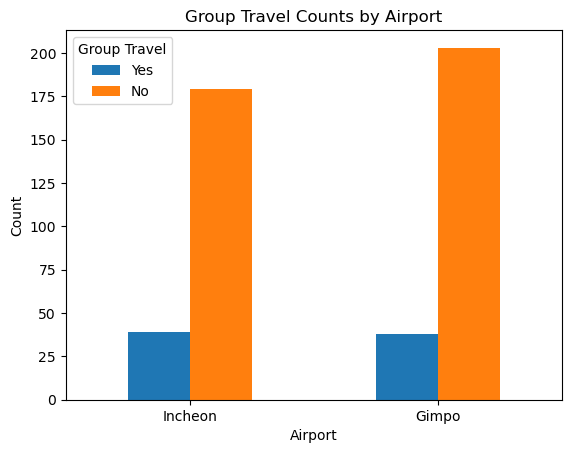

Sample size of each groups:
77
382
Chi-square test results:
Chi-square statistic: 0.23289608727983324, P-value: 0.6293846888213306
We fail to reject the null hypothesis: There is no significant association between GroupTravel and Airport selection.


In [12]:
#------- GROUPTRAVEL----------
#Visualization
gt_counts = airport.groupby('Airport')['GroupTravel'].value_counts().rename('Count').reset_index()

pivot_table = gt_counts.pivot(index='Airport', columns='GroupTravel', values='Count').fillna(0)

pivot_table.index = ['Incheon', 'Gimpo']
pivot_table.plot(kind='bar', stacked=False)

plt.xlabel('Airport')
plt.ylabel('Count')
plt.title('Group Travel Counts by Airport')
plt.xticks(rotation=0)  
plt.legend(title='Group Travel', labels=['Yes', 'No'])
plt.show()

#Check sample size of each group:
airport['GroupTravel[Yes]'] = (airport['GroupTravel'].isin([1])).astype(int)
airport['GroupTravel[No]'] = (airport['GroupTravel'].isin([2])).astype(int)
print('Sample size of each groups:')
print(airport['GroupTravel[Yes]'].sum())
print(airport['GroupTravel[No]'].sum())

#Chi-square:
contingency_table = pd.crosstab(airport['Airport'], [airport['GroupTravel[Yes]'], airport['GroupTravel[No]']])
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-square test results:\nChi-square statistic: {chi2}, P-value: {p}")
alpha = 0.05
if p < alpha:
    print("We reject the null hypothesis: There is a significant association between GroupTravel and Airport selection.")
else:
    print("We fail to reject the null hypothesis: There is no significant association between GroupTravel and Airport selection.")


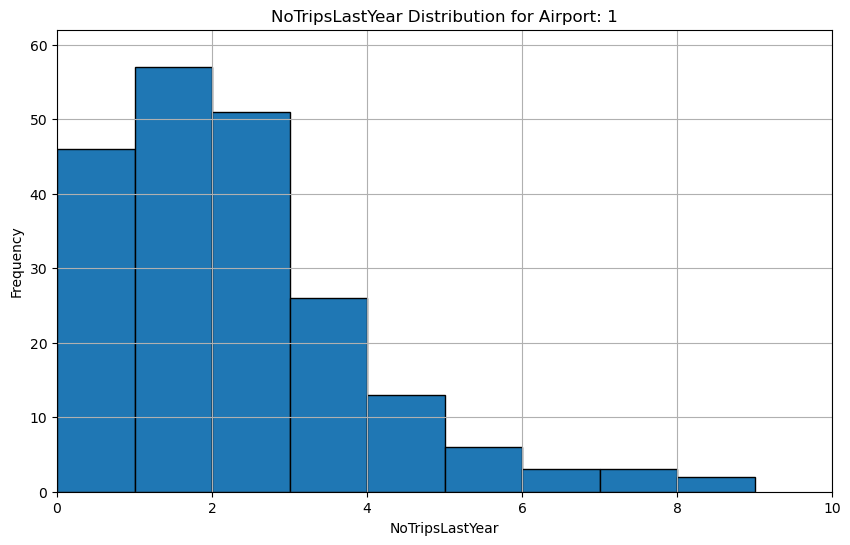

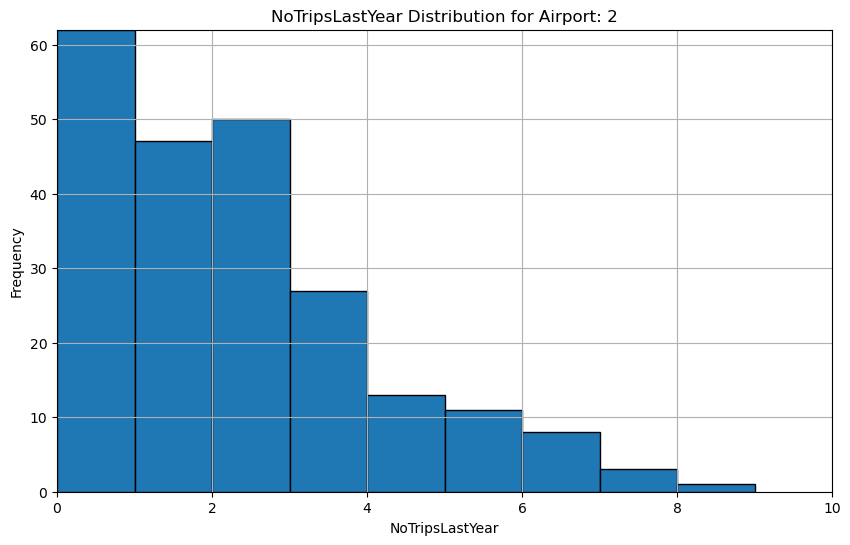


Kruskal test result:
The p-value is greater than or equal to 0.05 , so we fail to reject the null hypothesis.
There is no statistically significant difference in average NoTripsLastYear between Airport 1 and Airport 2.


In [20]:
#--------- NoTripsLastYear -----------
#Visualization
grouped = airport.groupby('Airport')
max_count = 0
for name, group in grouped:
    counts, _ = np.histogram(group['NoTripsLastYear'], bins=range(0, 10, 1)) #Already exclude outliners
    max_count = max(max_count, max(counts))
for name, group in grouped:
    plt.figure(figsize=(10, 6))
    plt.hist(group['NoTripsLastYear'], bins=range(0, 10, 1), edgecolor='black')
    plt.title(f'NoTripsLastYear Distribution for Airport: {name}')
    plt.xlabel('NoTripsLastYear')
    plt.ylabel('Frequency')
    plt.ylim(0, max_count)  
    plt.xlim(0, 10)  
    plt.grid(True)
    plt.show()
    
#ANOVA Test
airport_1 = airport[airport['Airport'] == 1]['NoTripsLastYear']
airport_2 = airport[airport['Airport'] == 2]['NoTripsLastYear']
kruskal_result = kruskal(airport_1, airport_2)
alpha = 0.05
print('\nKruskal test result:')
if kruskal_result.pvalue < alpha:
    print("The p-value is less than", alpha, ", so we reject the null hypothesis.")
    print("There is a statistically significant difference in average NoTripsLastYear between Airport 1 and Airport 2.")
else:
    print("The p-value is greater than or equal to", alpha, ", so we fail to reject the null hypothesis.")
    print("There is no statistically significant difference in average NoTripsLastYear between Airport 1 and Airport 2.")

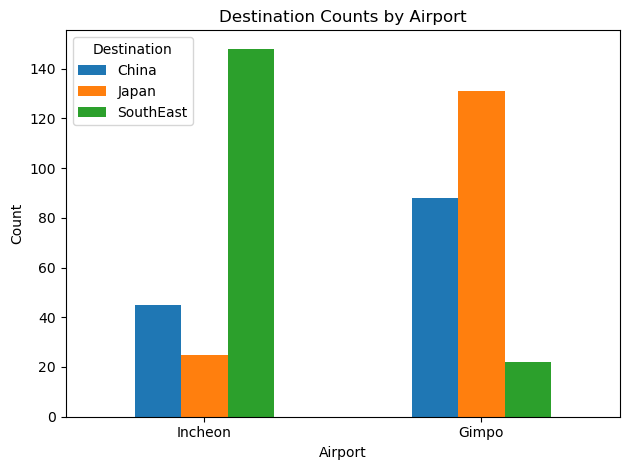

Sample size of each groups:
133
156
170

Chi-square test results:
Chi-square statistic: 178.6121045587186, P-value: 1.6401149771689017e-39
We reject the null hypothesis: There is a significant association between Destination and Airport selection.


In [119]:
#------- DESTINATION -------
#Visualization:
Destination_counts = airport.groupby('Airport')['Destination'].value_counts().rename('Count').reset_index()
pivot_table = Destination_counts.pivot(index= 'Airport', columns='Destination', values='Count').fillna(0)
pivot_table.index = ['Incheon', 'Gimpo']
pivot_table.plot(kind='bar', stacked=False)
plt.xlabel('Airport')
plt.ylabel('Count')
plt.title('Destination Counts by Airport')
plt.xticks(rotation=0)  # Set the x-axis labels to Airport names
plt.legend(title='Destination', labels=['China', 'Japan', 'SouthEast'])  
plt.tight_layout()
plt.show()

#Checking sample size each group:
airport['Destination[China]'] = (airport['Destination'] == 1).astype(int)
airport['Destination[Japan]'] = (airport['Destination'] == 2).astype(int)
airport['Destination[SE]'] = (airport['Destination'] == 3).astype(int)
print('Sample size of each groups:')
print(airport['Destination[China]'].sum())
print(airport['Destination[Japan]'].sum())
print(airport['Destination[SE]'].sum())

#Chi-Square
contingency_table = pd.crosstab(airport['Airport'], airport['Destination'])
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"\nChi-square test results:\nChi-square statistic: {chi2}, P-value: {p}")
alpha = 0.05
if p < alpha:
    print("We reject the null hypothesis: There is a significant association between Destination and Airport selection.")
else:
    print("We fail to reject the null hypothesis: There is no significant association between Destination and Airport selection.")

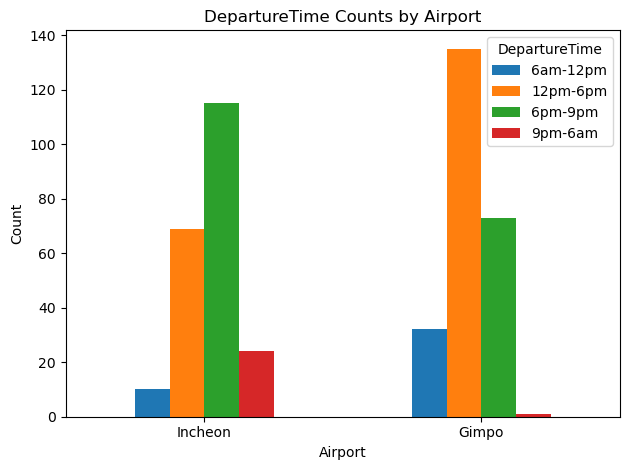


Chi-square test results:
Chi-square statistic: 62.423964628988756, P-value: 1.7832871105430952e-13
We reject the null hypothesis: There is a significant association between DepartureTime and Airline selection.


In [23]:
#---------- DEPARTURETIME-------------
#Visualization
DepartureTime_counts = airport.groupby('Airport')['DepartureTime'].value_counts().rename('Count').reset_index()
pivot_table = DepartureTime_counts.pivot(index= 'Airport', columns='DepartureTime', values='Count').fillna(0)
pivot_table.index = ['Incheon', 'Gimpo']
pivot_table.plot(kind='bar', stacked=False)
plt.xlabel('Airport')
plt.ylabel('Count')
plt.title('DepartureTime Counts by Airport')
plt.xticks(rotation=0)  # Set the x-axis labels to Airport names
plt.legend(title='DepartureTime', labels=["6am-12pm", "12pm-6pm", "6pm-9pm", "9pm-6am"])  # Update legend to match province residences
plt.tight_layout()
plt.show()

#Chi-square
contingency_table = pd.crosstab(airport['Airport'], airport['DepartureTime'])
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"\nChi-square test results:\nChi-square statistic: {chi2}, P-value: {p}")
alpha = 0.05
if p < alpha:
    print("We reject the null hypothesis: There is a significant association between DepartureTime and Airline selection.")
else:
    print("We fail to reject the null hypothesis: There is no significant association between DepartureTime and Airline selection.")

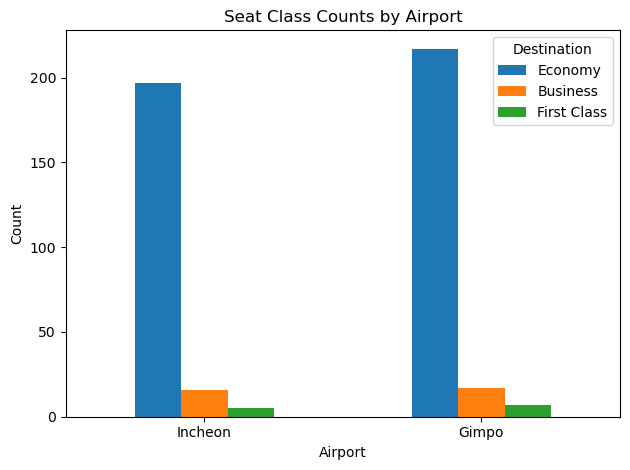

Sample size of each groups:
414
33
12

Chi-square test results:
Chi-square statistic: 0.17776083247555663, P-value: 0.9149549807915248
We fail to reject the null hypothesis: There is no significant association between SeatClass and Airline selection.


In [13]:
#-------- SEATCLASS ------------
#Visualization
sc_counts = airport.groupby('Airport')['SeatClass'].value_counts().rename('Count').reset_index()
pivot_table = sc_counts.pivot(index= 'Airport', columns='SeatClass', values='Count').fillna(0)
pivot_table.index = ['Incheon', 'Gimpo']
pivot_table.plot(kind='bar', stacked=False)
plt.xlabel('Airport')
plt.ylabel('Count')
plt.title('Seat Class Counts by Airport')
plt.xticks(rotation=0)  # Set the x-axis labels to Airport names
plt.legend(title='Destination', labels=['Economy', 'Business', 'First Class'])  
plt.tight_layout()
plt.show()

#Check sample size each group:
airport['SeatClass[Eco]'] = (airport['SeatClass'] == 1).astype(int)
airport['SeatClass[Business]'] = (airport['SeatClass'] == 2).astype(int)
airport['SeatClass[FirstClass]'] = (airport['SeatClass'] == 3).astype(int)
print('Sample size of each groups:')
print(airport['SeatClass[Eco]'].sum())
print(airport['SeatClass[Business]'].sum())
print(airport['SeatClass[FirstClass]'].sum())

#Chi-square
contingency_table = pd.crosstab(airport['Airport'], airport['SeatClass'])
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"\nChi-square test results:\nChi-square statistic: {chi2}, P-value: {p}")
alpha = 0.05
if p < alpha:
    print("We reject the null hypothesis: There is a significant association between SeatClass and Airline selection.")
else:
    print("We fail to reject the null hypothesis: There is no significant association between SeatClass and Airline selection.")

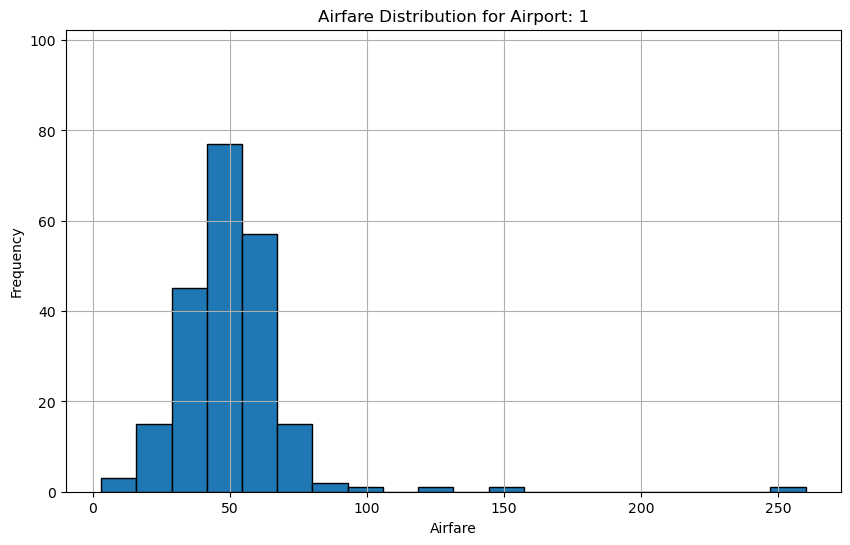

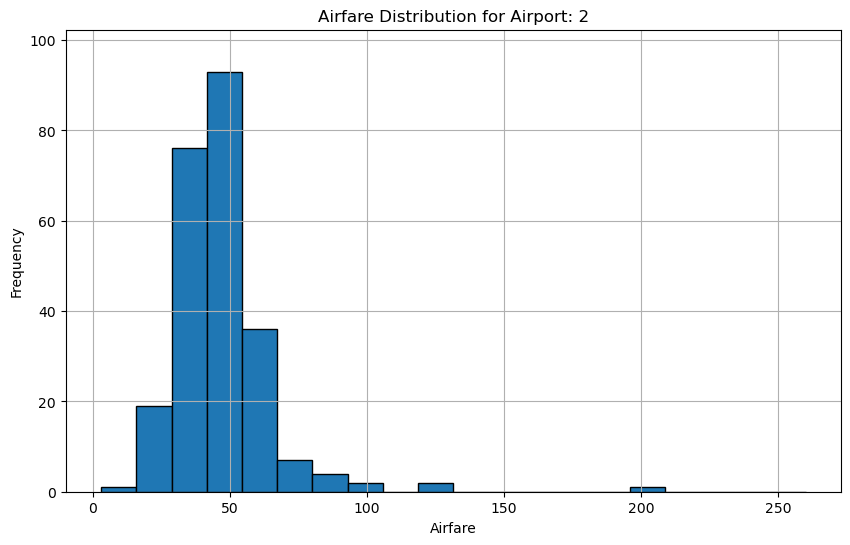


ANOVA test result:
The p-value is less than 0.1 , so we reject the null hypothesis.
There is a statistically significant difference in average Airfare between Airport 1 and Airport 2.


In [125]:
#--------- AIRFARE -----------
#Histogram - Check for Normal Distribution
grouped = airport.groupby('Airport')
af_min = airport['Airfare'].min()
af_max = airport['Airfare'].max()
max_count = 0
for name, group in grouped:
    counts, _ = np.histogram(group['Airfare'], bins=20, range=(af_min, af_max))
    max_count = max(max_count, counts.max())
for i, (name, group) in enumerate(grouped, start=1):
    plt.figure(figsize=(10, 6))
    counts, bins, patches = plt.hist(group['Airfare'], bins=20, edgecolor='black', range=(af_min, af_max))    
    plt.ylim(0, max_count * 1.1)  # Add a little extra space at the top    
    plt.title(f'Airfare Distribution for Airport: {name}')
    plt.xlabel('Airfare')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()
    
#ANOVA
airport_1 = airport[airport['Airport'] == 1]['Airfare']
airport_2 = airport[airport['Airport'] == 2]['Airfare']
anova_result = f_oneway(airport_1, airport_2)
alpha = 0.1
print('\nANOVA test result:')
if anova_result.pvalue < alpha:
    print("The p-value is less than", alpha, ", so we reject the null hypothesis.")
    print("There is a statistically significant difference in average Airfare between Airport 1 and Airport 2.")
else:
    print("The p-value is greater than or equal to", alpha, ", so we fail to reject the null hypothesis.")
    print("There is no statistically significant difference in average Airfare between Airport 1 and Airport 2.")

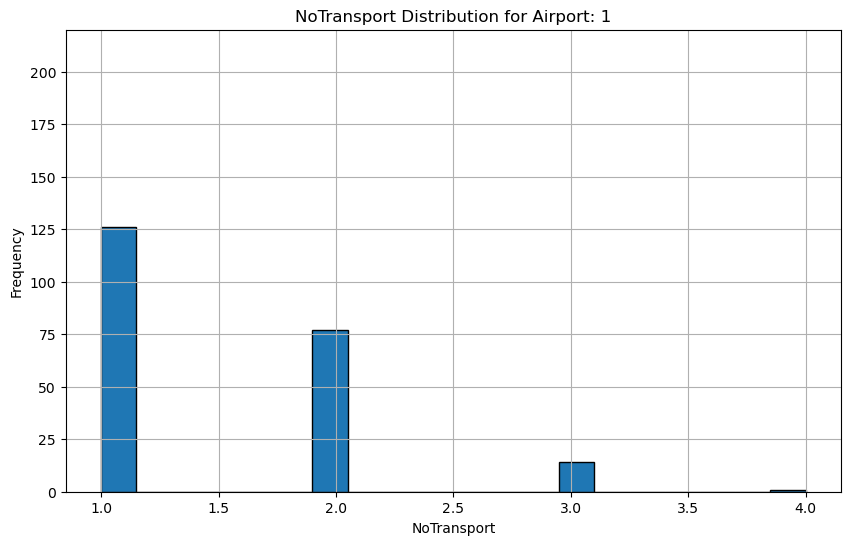

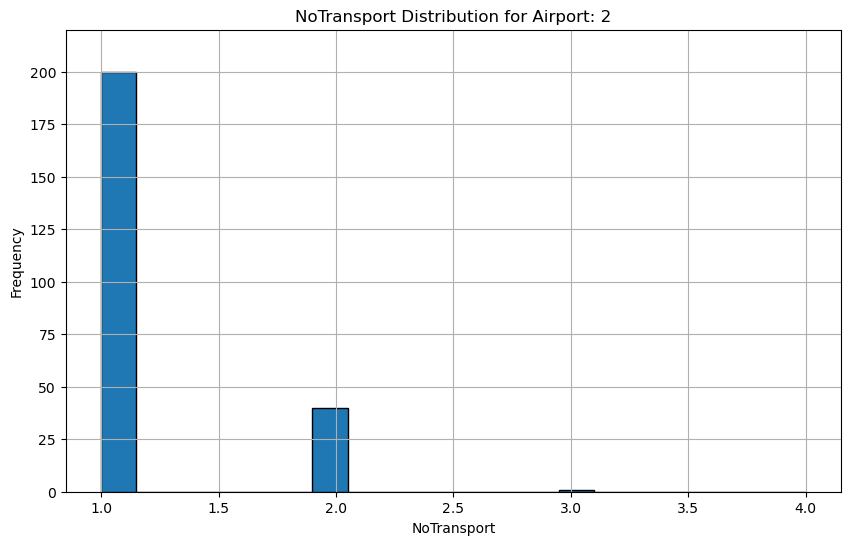


KRUSKAL test result:
The p-value is less than 0.05 , so we reject the null hypothesis.
There is a statistically significant difference in average NoTransport between Airport 1 and Airport 2.


In [132]:
#------ NoTransport -------
#Histogram - Check for Normal Distribution
grouped = airport.groupby('Airport')
nt_min = airport['NoTransport'].min()
nt_max = airport['NoTransport'].max()
max_count = 0
for name, group in grouped:
    counts, _ = np.histogram(group['NoTransport'], bins=20, range=(nt_min, nt_max))
    max_count = max(max_count, counts.max())
for i, (name, group) in enumerate(grouped, start=1):
    plt.figure(figsize=(10, 6))
    counts, bins, patches = plt.hist(group['NoTransport'], bins=20, edgecolor='black', range=(nt_min, nt_max))    
    plt.ylim(0, max_count * 1.1)  # Add a little extra space at the top    
    plt.title(f'NoTransport Distribution for Airport: {name}')
    plt.xlabel('NoTransport')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()
    
#KRUSKAL
airport_1 = airport[airport['Airport'] == 1]['NoTransport']
airport_2 = airport[airport['Airport'] == 2]['NoTransport']
kruskal_result = kruskal(airport_1, airport_2)
alpha = 0.05
print('\nKRUSKAL test result:')
if kruskal_result.pvalue < alpha:
    print("The p-value is less than", alpha, ", so we reject the null hypothesis.")
    print("There is a statistically significant difference in average NoTransport between Airport 1 and Airport 2.")
else:
    print("The p-value is greater than or equal to", alpha, ", so we fail to reject the null hypothesis.")
    print("There is no statistically significant difference in average NoTransport between Airport 1 and Airport 2.")

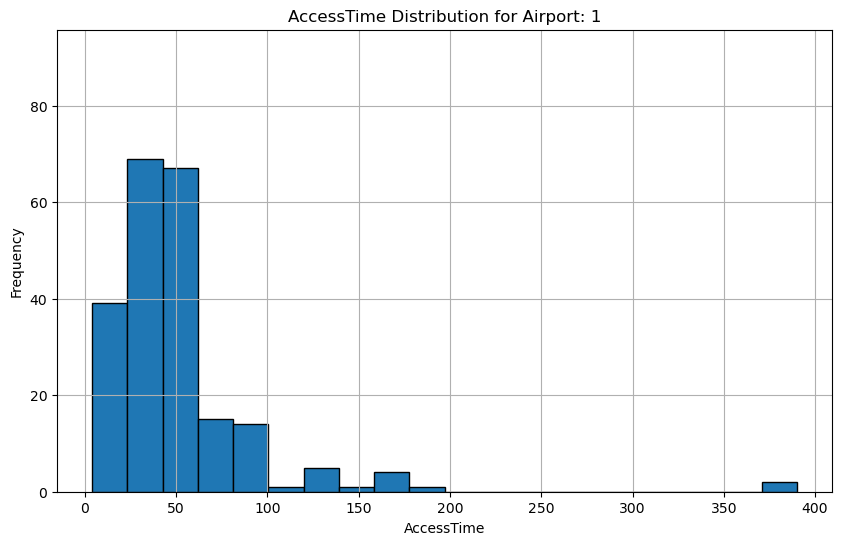

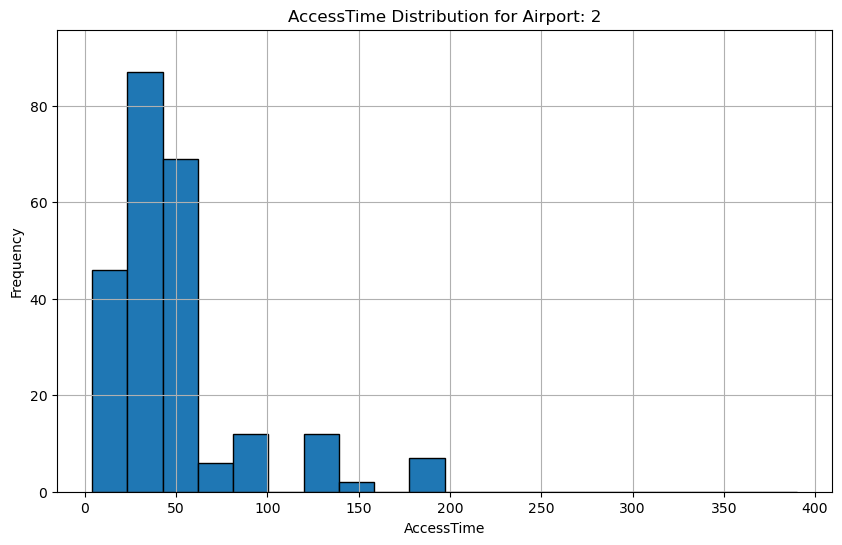


KRUSKAL test result:
The p-value is greater than or equal to 0.1 , so we fail to reject the null hypothesis.
There is no statistically significant difference in average AccessTime between Airport 1 and Airport 2.

Chi-square test results for AccessTime[<=30] vs AccessTime[>30]:
Chi-square statistic: 3.67936120817233
P-value: 0.05508995252161787
Degrees of freedom: 1
The p-value for AccessTime groups is less than 0.1, so we reject the null hypothesis.
There is a statistically significant association between AccessTime and Airport selection.


In [16]:
#-------- AccessTime -----------
#Histogram - Check for Normal Distribution
grouped = airport.groupby('Airport')
ct_min = airport['AccessTime'].min()
ct_max = airport['AccessTime'].max()
max_count = 0
for name, group in grouped:
    counts, _ = np.histogram(group['AccessTime'], bins=20, range=(ct_min, ct_max))
    max_count = max(max_count, counts.max())
for i, (name, group) in enumerate(grouped, start=1):
    plt.figure(figsize=(10, 6))
    counts, bins, patches = plt.hist(group['AccessTime'], bins=20, edgecolor='black', range=(ct_min, ct_max))    
    plt.ylim(0, max_count * 1.1)  # Add a little extra space at the top    
    plt.title(f'AccessTime Distribution for Airport: {name}')
    plt.xlabel('AccessTime')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

#KRUSKAL
airport_1 = airport[airport['Airport'] == 1]['AccessTime']
airport_2 = airport[airport['Airport'] == 2]['AccessTime']
kruskal_result = kruskal(airport_1, airport_2)
alpha = 0.10
print('\nKRUSKAL test result:')
if kruskal_result.pvalue < alpha:
    print("The p-value is less than", alpha, ", so we reject the null hypothesis.")
    print("There is a statistically significant difference in average AccessTime between Airport 1 and Airport 2.")
else:
    print("The p-value is greater than or equal to", alpha, ", so we fail to reject the null hypothesis.")
    print("There is no statistically significant difference in average AccessTime between Airport 1 and Airport 2.")
    
    
#CHI SQUARE for AccessTime[<=30] vs AccessTime[>30]
airport['AccessTime[<=30]'] = (airport['AccessTime']<=30).astype(int)
airport['AccessTime[>30]'] = (airport['AccessTime']>30).astype(int)
contingency_table = pd.crosstab(index=airport['Airport'], columns=[airport['AccessTime[<=30]'], airport['AccessTime[>30]']])
chi2, p, dof, ex = chi2_contingency(contingency_table)
print(f"\nChi-square test results for AccessTime[<=30] vs AccessTime[>30]:\nChi-square statistic: {chi2}\nP-value: {p}\nDegrees of freedom: {dof}")
alpha = 0.1
if p < alpha:
    print(f"The p-value for AccessTime groups is less than {alpha}, so we reject the null hypothesis.")
    print("There is a statistically significant association between AccessTime and Airport selection.")
else:
    print(f"The p-value for AccessTime groups is greater than or equal to {alpha}, so we fail to reject the null hypothesis.")
    print("There is no statistically significant association between AccessTime and Airport selection.")

<Figure size 1000x600 with 0 Axes>

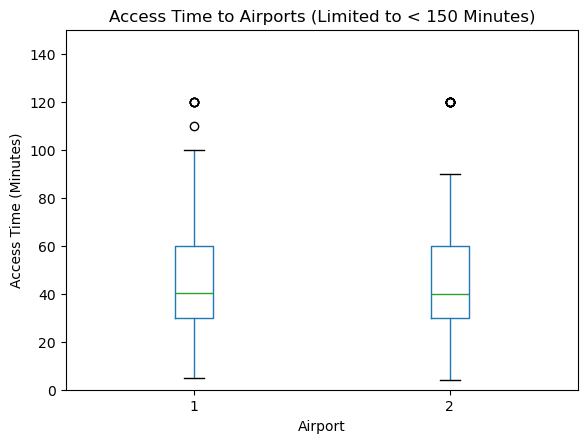

"AccessTime[<=30]: identified the first quartile (25th percentile) as the cutoff, which means that we're \nfocusing on the fastest 25% of travelers to each airport."

In [36]:
#------ AccessTime (cont) ----------
#Choosing range:
# Filter the DataFrame to exclude AccessTime values of 150 or greater
airport_filtered = airport[airport['AccessTime'] < 150]
# Create the box plots
plt.figure(figsize=(10, 6))
airport_filtered.boxplot(column='AccessTime', by='Airport', grid=False)
plt.title('Access Time to Airports (Limited to < 150 Minutes)')
plt.suptitle('')  
plt.xlabel('Airport')
plt.ylabel('Access Time (Minutes)')
plt.ylim(0, 150)
plt.show()

'''AccessTime[<=30]: identified the first quartile (25th percentile) as the cutoff, which means that we're 
focusing on the fastest 25% of travelers to each airport.'''